In [65]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import tqdm

In [66]:
def calc_length(arr):
    res = 0
    for s in (0, 4):
        res += ((arr[s] - arr[s + 2]) ** 2 +
                (arr[s + 1] - arr[s + 3]) ** 2)
    return res


def min_length(arr):
    res = 100
    arr = arr[:8]
    #numpyに
    arr = np.array(arr)
    for s in (0,4):
        res = min(res, (arr[s] - arr[s + 2]) ** 2 +
                  (arr[s + 1] - arr[s + 3]) ** 2)
    print(f"\r{res}",end="")
    return res

def cherry_pick(df,threshold=10):
    # data[:8]のmin_lengthが10未満のものをdrop
    df = df.apply(lambda x: min_length(x) >= threshold, axis=0)



In [67]:
prefix = "new30"
for i in range(10):
    filename = f"{prefix}/{prefix}_{i}.csv"
    # csvファイルの読み込み
    if i == 0:
        df = pd.read_csv(filename, header=0)
        df = df.drop("Unnamed: 0", axis=1)
    else:
        tmp = pd.read_csv(filename, header=0)
        tmp = tmp.drop("Unnamed: 0", axis=1)
        df = pd.concat([df, tmp], axis=0)

#cherry_pick(df)


#dataframeをnumpy配列に変換
data = df.values
#深層学習の入力データと出力データに分ける
# 入力データ
len_test = 8
x = data[:, len_test:]

#x[i]をN×Nに変換
siz = 32
x = x.reshape(-1, siz,siz)

# 出力データ
y = data[:, :len_test]
#入力データの正規化
x = (x - x.mean()) / x.std()

#入力データの各行をN×Nに変換


#出力データのMin-Max正規化
y = (y - y.min()) / (y.max() - y.min())

#入力データの次元数
input_dim = x.shape[1]

#出力データの次元数
output_dim = y.shape[1]

#入力データの数
n = x.shape[0]

#学習データとテストデータに分ける
#学習データ
x_train = x[:int(n*0.8)]
y_train = y[:int(n*0.8)]

#テストデータ
x_test = x[int(n*0.8):]
y_test = y[int(n*0.8):]


N = siz



2.3665253307230564e-06

C:\Users\Dette\AppData\Local\Temp\ipykernel_2440\837478395.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  arr = arr[:8]


In [68]:

#optunaを使わないCNN
def create_model():
    # モデルの定義
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights=None,
        input_shape=(N, N, 1),
    )

    #8個の出力を持つモデル
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(N, N, 1)),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8),
    ])
    
    # モデルのコンパイル
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mse"],
    )
    return model


#学習の実行
def objective():
    model = create_model()
    history = model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, y_test),
    )
    #学習の様子をプロット
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    return model, history
model,history = objective()

Epoch 1/100
250/250 [==============================] - 21s 57ms/step - loss: 0.2082 - mse: 0.2082 - val_loss: 0.1045 - val_mse: 0.1045
Epoch 2/100
 22/250 [=>............................] - ETA: 11s - loss: 0.0995 - mse: 0.0995

KeyboardInterrupt: 

In [ ]:
#1行目の値を実際に計算
print(model.predict(x_test[:1]))
#実際の値
print(y_test[:1])

1/1 [==============================] - 1s 1s/step
[[0.35081166 0.5795029  0.72947747 0.3566371  0.48537606 0.4009258
  0.31760776 0.48536482]]
[[0.10714286 0.71428571 0.60714286 0.32142857 0.17857143 0.92857143
  0.28571429 0.67857143]]


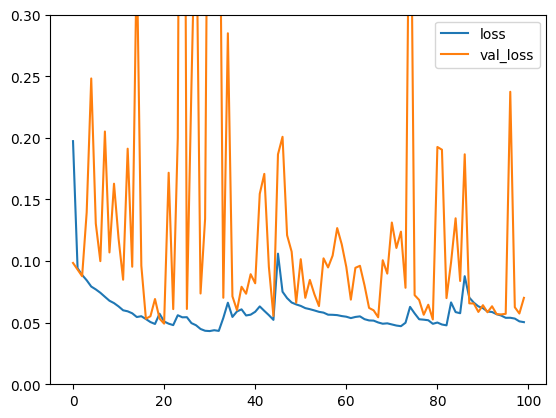

In [ ]:
#片対数プロット

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
#plotの上限を設定
plt.ylim(0, 0.3)
plt.legend()
ax = plt.gca()
plt.show()
